In [1]:
import time
import datetime
import sys
import numpy as np
from TimeTagger import Coincidences, Counter, Correlation, createTimeTagger, freeTimeTagger, Countrate, CoincidenceTimestamp, Coincidence
import matplotlib.pyplot as plt
from pylablib.devices import Thorlabs

In [2]:
stage = Thorlabs.KinesisMotor("55457934")

In [3]:
stage.home()
stage.wait_for_stop()

In [4]:
stage.get_position()

50517333

In [5]:
stage.get_full_info() # 1 deg = 136533 step

{'velocity_parameters': TVelocityParams(min_velocity=0.0, acceleration=1365308.1844171758, max_velocity=1365513.6922503726),
 'jog_parameters': TJogParams(mode='step', step_size=682667, min_velocity=0.0, acceleration=2047962.2766257639, max_velocity=2048270.5476900148, stop_mode='profiled'),
 'homing_parameters': THomeParams(home_direction='reverse', limit_switch='reverse', velocity=1365513.6922503726, offset_distance=546133),
 'gen_move_parameters': TGenMoveParams(backlash_distance=136533),
 'limit_switch_parameters': TLimitSwitchParams(hw_kind_cw='make_home', hw_kind_ccw='ignore', hw_swapped=False, sw_position_cw=136533, sw_position_ccw=136533, sw_kind='ignore'),
 'position': 50517333,
 'status': ['homed', 'enabled'],
 'cls': 'KinesisMotor',
 'conn': {'port': '55457934',
  'baudrate': 115200,
  'bytesize': 8,
  'parity': 'N',
  'stopbits': 1,
  'xonxoff': 0,
  'rtscts': True},
 'device_info': TDeviceInfo(serial_no=55457934, model_no='K10CR1', fw_ver='1.0.3', hw_type=16, hw_ver=3, mod

In [6]:
stage.move_to(0)
stage.wait_for_stop()

In [7]:
# 2) init tagger

tagger = createTimeTagger()
for j in range(1, 17):
    tagger.setTriggerLevel(j, 0.8)

tagger.setInputDelay(11, 6065)

coin = Coincidence(
                tagger, [5, 11], coincidenceWindow=5000, timestamp=CoincidenceTimestamp.Average
                )

countrate = Countrate(tagger=tagger, channels=coin.getChannels())

# 3) measure

t = datetime.datetime.now()
start_time = t.strftime("%y.%m.%d_%H.%M.%S")
filename = f"data_Haifei/rotate_{start_time}.txt"
f = open(filename, "w")

step = 1
sec = 1
counts = []

# center = 180 * 136533
# ran = round(180 * 136533)
# range_max = center + ran
# range_min = center - ran

range_min = 0 * 136533
range_max = 360 * 136533

estimated_time = ( sec * (range_max - range_min) / (step * 136533) ) / 60

estimated_finish_time = (t + datetime.timedelta(minutes=estimated_time)).strftime("%y.%m.%d_%H.%M.%S")

print(f"Start time : {start_time}")
print(f"Estimated time : {estimated_time : .0f} min")
print(f"Estimated finish time : {estimated_finish_time}")

try:
    for pos in range(range_min, range_max, int(step*136533)):
        print(f"Moving to position {pos/136533:.3f} deg...")
        stage.move_to(pos)
        stage.wait_for_stop()
        cur_pos = stage.get_position()
        print(f"Current position: {cur_pos/136533:.3f} deg")
        print("Performing coincidence counting...")
        countrate.startFor(int(sec*1e12))
        for i in range(0, sec):
            sys.stdout.write("\r")
            sys.stdout.write(f"Time remaining: {(int(sec) - i):4d} s")
            sys.stdout.flush()
            time.sleep(1)
        print("\n")
        countrate.waitUntilFinished()
        count = countrate.getCountsTotal()
        print("counts: ", count)
        pos_count = [cur_pos] + [int(num) for num in count]
        counts.append(count)

        f.write(" ".join(map(str, pos_count)))
        f.write("\n")
        f.flush()
except Exception as e:
    raise e
finally:
    f.close()
    freeTimeTagger(tagger=tagger)

Start time : 25.03.24_18.51.53
Estimated time :  6 min
Estimated finish time : 25.03.24_18.57.53
Moving to position 0.000 deg...
Current position: 0.000 deg
Performing coincidence counting...
Time remaining:    1 s

counts:  [920]
Moving to position 1.000 deg...
Current position: 1.000 deg
Performing coincidence counting...
Time remaining:    1 s

counts:  [919]
Moving to position 2.000 deg...
Current position: 2.000 deg
Performing coincidence counting...
Time remaining:    1 s

counts:  [930]
Moving to position 3.000 deg...
Current position: 3.000 deg
Performing coincidence counting...
Time remaining:    1 s

counts:  [814]
Moving to position 4.000 deg...
Current position: 4.000 deg
Performing coincidence counting...
Time remaining:    1 s

counts:  [857]
Moving to position 5.000 deg...
Current position: 5.000 deg
Performing coincidence counting...
Time remaining:    1 s

counts:  [836]
Moving to position 6.000 deg...
Current position: 6.000 deg
Performing coincidence counting...
Time

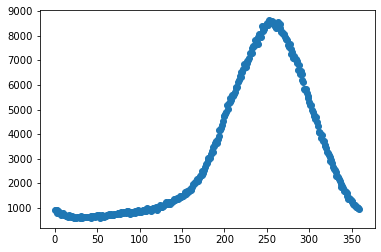

In [8]:
plt.plot(counts, "o")
plt.savefig(filename[:-4] + '.jpg')
plt.show()

In [22]:
stage.move_to(102 * 136533)

In [23]:
stage.move_to(0 * 136533)
stage.wait_for_stop()
stage.move_to(360 * 136533)
stage.wait_for_stop()

In [24]:
stage.close()